In [1]:
# Literate.notebook("equirect1.jl"; execute=false)

Modules
==============================

In [2]:
using Tullio
using PyPlot
using BenchmarkTools
using ProgressMeter
using LinearAlgebra
using FFTW
FFTW.set_num_threads(Threads.nthreads())

using CMBLensing
import CMBLensing: Map, AzFourier, QUAzFourier, QUMap, m_fft, m_rfft, m_irfft,  m_ifft
using CirculantCov: βcovSpin2, βcovSpin0, geoβ,
multPP̄, multPP, periodize, Jperm # https://github.com/EthanAnderes/CirculantCov.jl

# LATER: remove LBblock dependence
using LBblocks: @sblock # https://github.com/EthanAnderes/LBblocks.jl

hide_plots = false

using Test

Methods ...
=======================================

EquiRectS0:

In [3]:
function tulliomult(M▫, f::Union{EquiRectAzFourier, EquiRectMap})
    m▫ = AzFourier(f).arr
    @tullio n▫[i,m] :=  M▫[i,j,m] * m▫[j,m]
    EquiRectAzFourier(n▫, f.metadata)
end

tulliomult (generic function with 1 method)

EquiRectS2:

In [4]:
function tulliomult(M▫, f::Union{EquiRectQUAzFourier, EquiRectQUMap})
    m▫ = QUAzFourier(f).arr
    @tullio n▫[i,m] :=  M▫[i,j,m] * m▫[j,m]
    EquiRectQUAzFourier(n▫, f.metadata)
end

tulliomult (generic function with 2 methods)

Set the grid geometry
============================

In [5]:
pj = @sblock let

    φ, φ∂ = CMBLensing.φ_grid(; φspan=(0.0, 2π/4), N=768)
    # φ, φ∂ = CMBLensing.φ_grid(; φspan=(0.0, 2π/4), N=1024)

    θ, θ∂ = CMBLensing.θ_grid(; θspan=(2.3,2.7), N= 1270, type=:equicosθ)
    # θ, θ∂ = CMBLensing.θ_grid(; θspan=(2.3,2.7), N= 512, type=:healpix)
    # θ, θ∂ = CMBLensing.θ_grid(; θspan=(2.3,2.7), N= 2372, type=:equiθ)

    CMBLensing.ProjEquiRect(; θ, φ, θ∂, φ∂)
end;

In [6]:
@test pj.Ny == length(pj.θ)
@test pj.Nx == length(pj.φ)

Test Passed

This makes a linear list `θ∂[1], θ[1], θ∂[2], θ[2], ..., θ∂[n], θ[n], θ∂[n+1]`
which should be strictly increasting.

In [7]:
∂θ∂ = vcat(vcat(pj.θ∂[1:end-1]', pj.θ')[:],  pj.θ∂[end])
@test all(diff(∂θ∂) .> 0)

Test Passed

In [8]:
let θ∂ = [pi/2, 3pi/4, pi]
    Ω = 2π .* diff(.- cos.(θ∂))
    @test sum(Ω) ≈ 4pi/2
end

Test Passed

In [9]:
@show extrema(@. rad2deg(√pj.Ω)*60)

extrema(#= In[9]:1 =# @__dot__(rad2deg(√(pj.Ω)) * 60)) = (4.362660623770893, 4.362668862787271)


(4.362660623770893, 4.362668862787271)

Plot √Ωpix over ring θ's

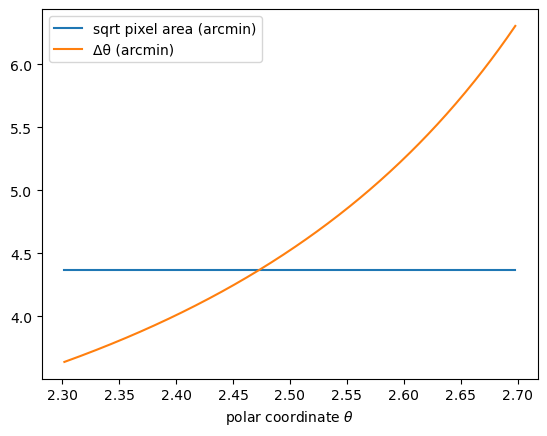

In [10]:
@sblock let pj, hide_plots
    hide_plots && return
    fig,ax = subplots(1)
    ax.plot(pj.θ, rad2deg.(.√pj.Ω)*60, label="sqrt pixel area (arcmin)")
    ax.plot(pj.θ, rad2deg.(diff(pj.θ∂))*60, label="Δθ (arcmin)")
    ax.set_xlabel(L"polar coordinate $\theta$")
    ax.legend()
    return nothing
end

Quick test
============================

In [11]:
ϕ = EquiRectMap(randn(Float64, pj.Ny, pj.Nx), pj)
P = EquiRectQUMap(randn(ComplexF64, pj.Ny, pj.Nx), pj);

In [12]:
ϕ′ = AzFourier(ϕ)
P′ = QUAzFourier(P);

In [13]:
@test AzFourier(ϕ′) isa EquiRectAzFourier
@test QUAzFourier(P′) isa EquiRectQUAzFourier

@test all(Map(AzFourier(ϕ′)).arr .≈ ϕ′[:])
@test all(QUMap(QUAzFourier(P′)).arr .≈ P′[:])

Test Passed

In [14]:
2 * ϕ + ϕ′
2 * P + P′;

Spectral densities
==============================

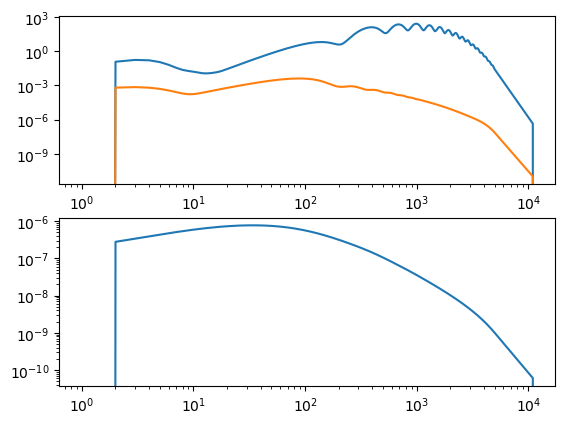

In [15]:
ℓ, CEEℓ, CBBℓ, CΦΦℓ = @sblock let ℓmax = 11000
	ℓ    = 0:ℓmax
	Cℓ   = camb(;r=0.01, ℓmax);
	CBBℓ = Cℓ.tensor.BB(ℓ)
	CEEℓ = Cℓ.unlensed_scalar.EE(ℓ)
	CΦΦℓ = Cℓ.unlensed_scalar.ϕϕ(ℓ)
	for cl in (CEEℓ, CBBℓ, CΦΦℓ)
		cl[.!isfinite.(cl)] .= 0
	end

	return ℓ, CEEℓ, CBBℓ, CΦΦℓ
end

@sblock let hide_plots, ℓ, CEEℓ, CBBℓ, CΦΦℓ
	hide_plots && return
	fig, ax = subplots(2)
	ax[1].plot(ℓ, @. ℓ^2*CEEℓ)
	ax[1].plot(ℓ, @. ℓ^2*CBBℓ)
	ax[2].plot(ℓ, @. ℓ^4*CΦΦℓ)
	ax[1].set_xscale("log")
	ax[2].set_xscale("log")
	ax[1].set_yscale("log")
	ax[2].set_yscale("log")
	return nothing
end

Block diagonal cov matrices
==============================

In [16]:
EB▫, Phi▫  = @sblock let ℓ, CEEℓ, CBBℓ, CΦΦℓ, θ=pj.θ, φ=pj.φ, freq_mult=pj.φspan_ratio

    nθ, nφ = length(θ), length(φ)
    nφ2π  = nφ*freq_mult
    φ2π   = 2π*(0:nφ2π-1)/nφ2π |> collect

    covβEB   = βcovSpin2(ℓ, CEEℓ, CBBℓ, ngrid=50_000)
    covβPhi  = βcovSpin0(ℓ, CΦΦℓ,       ngrid=50_000)

    ptmW    = FFTW.plan_fft(Vector{ComplexF64}(undef, nφ))
    EBγⱼₖ   = zeros(ComplexF64, nφ)
    EBξⱼₖ   = zeros(ComplexF64, nφ)
    Phiγⱼₖ  = zeros(ComplexF64, nφ)

    T     = ComplexF64 # ComplexF32
    rT    = real(T)
    EB▫   = zeros(T,2nθ,2nθ,nφ÷2+1)
    Phi▫  = zeros(rT,nθ,nθ,nφ÷2+1)

    prgss = Progress(nθ, 1, "EB▫, Phi▫")
    for k = 1:nθ
        for j = 1:nθ
            θ1, θ2 = θ[j], θ[k]
            β      = geoβ.(θ1, θ2, φ2π[1], φ2π)

            covΦΦ̄  = covβPhi(β)
            covPP̄, covPP = covβEB(β)
            covPP̄ .*= multPP̄.(θ1, θ2, φ2π[1], φ2π)
            covPP .*= multPP.(θ1, θ2, φ2π[1], φ2π)

            # periodize and restrict from φ2π to φ
            covΦΦ̄′   = periodize(covΦΦ̄, freq_mult)
            covPP̄′   = periodize(covPP̄, freq_mult)
            covPP′   = periodize(covPP, freq_mult)

            mul!(Phiγⱼₖ,  ptmW, covΦΦ̄′)
            mul!(EBγⱼₖ,   ptmW, covPP̄′)
            mul!(EBξⱼₖ,   ptmW, covPP′)

            @inbounds for ℓ = 1:nφ÷2+1
                Jℓ = Jperm(ℓ, nφ) # ℓ==1 ? 1 : nφ - ℓ + 2
                Phi▫[j,  k,    ℓ] = real(Phiγⱼₖ[ℓ])
                EB▫[j,   k,    ℓ] = EBγⱼₖ[ℓ]
                EB▫[j,   k+nθ, ℓ] = EBξⱼₖ[ℓ]
                EB▫[j+nθ,k,    ℓ] = conj(EBξⱼₖ[Jℓ])
                EB▫[j+nθ,k+nθ, ℓ] = conj(EBγⱼₖ[Jℓ])
            end
        end
        next!(prgss)
    end

    @show Base.summarysize(EB▫) / 1e9
    @show Base.summarysize(Phi▫)  / 1e9

    return EB▫, Phi▫
end;

EB▫, Phi▫100%|██████████████████████████████████████████| Time: 0:01:40


Base.summarysize(EB▫) / 1.0e9 = 2.217600048
Base.summarysize(Phi▫) / 1.0e9 = 0.277200048


In [17]:
EB▫½, Phi▫½ = @sblock let EB▫, Phi▫
    EB▫½  = similar(EB▫)
    Phi▫½ = similar(Phi▫)
    for b in axes(EB▫,3)
        # EB▫½[:,:,b]  .= sqrt(Hermitian(EB▫[:,:,b]))
        # Phi▫½[:,:,b] .= sqrt(Symmetric(Phi▫[:,:,b]))
        # ... or ...
        try
            EB▫½[:,:,b]  .= Matrix(cholesky(Hermitian(EB▫[:,:,b])).L)
            Phi▫½[:,:,b] .= Matrix(cholesky(Symmetric(Phi▫[:,:,b])).L)
        catch
            @show b
            break
        end
    end
    EB▫½, Phi▫½
end;

Test simulation of ϕmap, Qmap, Umap
=======================================

Field sim unit noise

In [18]:
ϕ′ = EquiRectMap(  randn(Float64,    pj.Ny, pj.Nx), pj)
P′ = EquiRectQUMap(randn(ComplexF64, pj.Ny, pj.Nx), pj);

generate simulation

In [19]:
ϕsim = tulliomult(Phi▫½,  ϕ′)
Psim = tulliomult(EB▫½, P′);

plot maps of the simulated fields

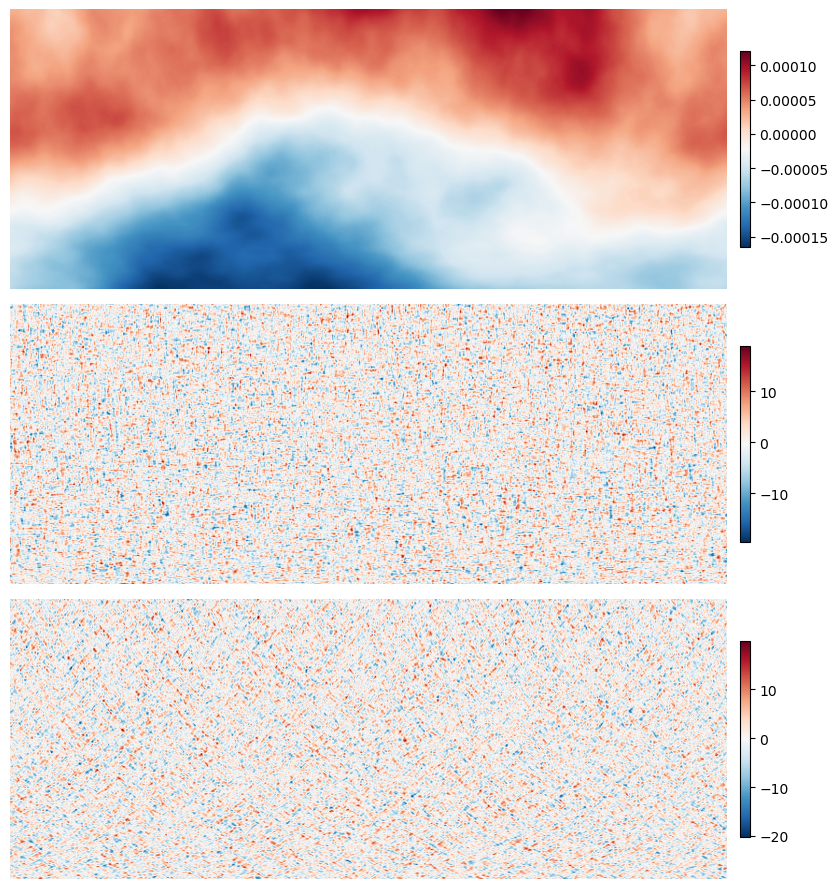

In [20]:
@sblock let ϕsim, Psim, hide_plots
    hide_plots && return
    fig,ax = subplots(3,figsize=(9,9))
    ϕsim[:]  |> imshow(-, fig, ax[1])
    Psim[:] .|> real |> imshow(-, fig, ax[2]) # Qsim
    Psim[:] .|> imag |> imshow(-, fig, ax[3]) # Usim
    return nothing
end

gradient(x-> dot(Map(x), Map(x)), ϕsim)[1]

TODO:
=======================================
• Block field operators and all the stuff to go with it
• Need to make sure the sign of U matches CMBLensing ... probably just need a negative spin 2 option in CirculantCov

---

*This notebook was generated using [Literate.jl](https://github.com/fredrikekre/Literate.jl).*